In [1]:
# %load_ext autoreload
# %autoreload 2

import sys
sys.path.append('..')

%env WORKDIR=/Users/jitang/Dev/workdir

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from eofs.xarray import Eof
import cartopy.crs as ccrs

from lib.reanalysis import r1
from lib import obs
from lib.plotting import maps
from lib.enso import oni_trimonthly

env: WORKDIR=/Users/jitang/Dev/workdir


In [2]:
sfo = obs.daily_summary('SFO', '1980-07-01', '2021-06-01')
sfo.loc[sfo.day == '2008-01-03', 'precip_in'] = 0.17
sfo.loc[sfo.day == '2008-01-04', 'precip_in'] = 2.10
sfo.loc[sfo.day == '2008-01-05', 'precip_in'] = 0.77
sfo.loc[sfo.precip_in < 0.1, 'precip_in'] = 0

data_cols = ['day', 'precip_in', 'max_temp_f', 'min_temp_f']

sfo_monthly = sfo[data_cols].resample('MS', on='day').agg({
    'precip_in': np.sum,
    'max_temp_f': np.mean,
    'min_temp_f': np.mean
}).reset_index()

djf = sfo_monthly[sfo_monthly.day.dt.month.isin([11, 12, 1, 2, 3])]

In [3]:
djf.precip_in.describe()

count    205.000000
mean       3.126049
std        2.641378
min        0.000000
25%        1.120000
50%        2.360000
75%        4.790000
max       13.520000
Name: precip_in, dtype: float64

In [54]:
wet_top50 = djf.sort_values(by='precip_in', ascending=False).head(50)

In [55]:
oni = oni_trimonthly()
wet_top50['month'] = wet_top50.day.dt.month
wet_top50['year'] = wet_top50.day.dt.year

oni_relevant = oni[['ANOM', 'MONTH', 'YR']]
oni_relevant.columns = ['ONI', 'month', 'year']
wet_top50 = wet_top50.merge(oni_relevant)

In [116]:
wet_nino = wet_top50[wet_top50.ONI >= 1.0]
wet_non_nino = wet_top50[wet_top50.ONI < 1.0]

bbox = (0, 360, 90, 10)

_, _, wet_nino_anoms = r1.hgt_monthly(500, yearmonths=wet_nino.day, bbox=bbox)
_, _, wet_non_nino_anoms = r1.hgt_monthly(500, yearmonths=wet_non_nino.day, bbox=bbox)

In [123]:
dry_top40 = djf.sort_values(by='precip_in', ascending=False).tail(40)
_, _, dry_anoms = r1.hgt_monthly(500, yearmonths=dry_top40.day, bbox=bbox)

In [120]:
len(wet_nino), len(wet_non_nino)

(13, 37)

In [119]:
wet_nino.sort_values(by='day', ascending=False)

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI
48,2016-03-01,5.05,63.870968,51.580645,3,2016,1.58
44,2016-01-01,5.31,57.000000,48.387097,1,2016,2.48
34,2010-01-01,5.94,55.645161,46.838710,1,2010,1.50
4,2002-12-01,9.37,57.774194,47.612903,12,2002,1.14
0,1998-02-01,13.52,56.714286,47.750000,2,1998,1.93
14,1998-01-01,7.77,57.290323,48.516129,1,1998,2.24
32,1997-11-01,5.97,63.200000,52.266667,11,1997,2.40
43,1994-11-01,5.45,56.100000,44.100000,11,1994,1.01
27,1992-02-01,6.22,62.655172,49.275862,2,1992,1.63
10,1983-03-01,8.26,59.000000,49.193548,3,1983,1.54


In [121]:
wet_non_nino.sort_values(by='day', ascending=False)

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI
18,2019-02-01,7.20,55.892857,44.071429,2,2019,0.72
17,2017-02-01,7.24,59.785714,49.178571,2,2017,-0.16
5,2017-01-01,9.19,56.451613,43.709677,1,2017,-0.34
2,2014-12-01,10.47,61.580645,51.935484,12,2014,0.66
26,2012-12-01,6.23,57.290323,46.387097,12,2012,-0.21
46,2011-03-01,5.13,59.870968,47.548387,3,2011,-0.93
37,2010-12-01,5.80,56.709677,47.483871,12,2010,-1.59
25,2009-02-01,6.24,58.107143,46.035714,2,2009,-0.79
3,2008-01-01,9.87,53.036774,43.682581,1,2008,-1.64
42,2006-03-01,5.63,56.935484,43.806452,3,2006,-0.57


In [124]:
dry_top40.sort_values(by='day', ascending=False)

,day,precip_in,max_temp_f,min_temp_f
484,2020-11-01,0.27,64.500000,46.566667
475,2020-02-01,0.00,64.551724,46.137931
451,2018-02-01,0.35,63.678571,46.035714
449,2017-12-01,0.00,59.258065,44.322581
416,2015-03-01,0.00,68.903226,51.709677
414,2015-01-01,0.00,61.000000,46.870968
402,2014-01-01,0.00,64.064516,46.129032
401,2013-12-01,0.29,58.161290,41.290323
392,2013-03-01,0.24,62.483871,46.774194
391,2013-02-01,0.67,58.500000,43.214286


In [59]:
def plot_nhem_anoms(da, cmap, levels, title, draw=True):
    proj = ccrs.NorthPolarStereo(central_longitude=-94.5, true_scale_latitude=None, globe=None)
    m = maps.CartopyMap(proj=proj)
    if draw:
        m.draw()
    m.plot.fill(da, cmap, levels, colorbar=True, colorbar_label='Geopotential height anomaly (dm)')
    m.textbox.bottom_right(title, fontsize=20)
    m.textbox.top_left('by Jim Tang (@wxmann)', fontsize=16)
    return m

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


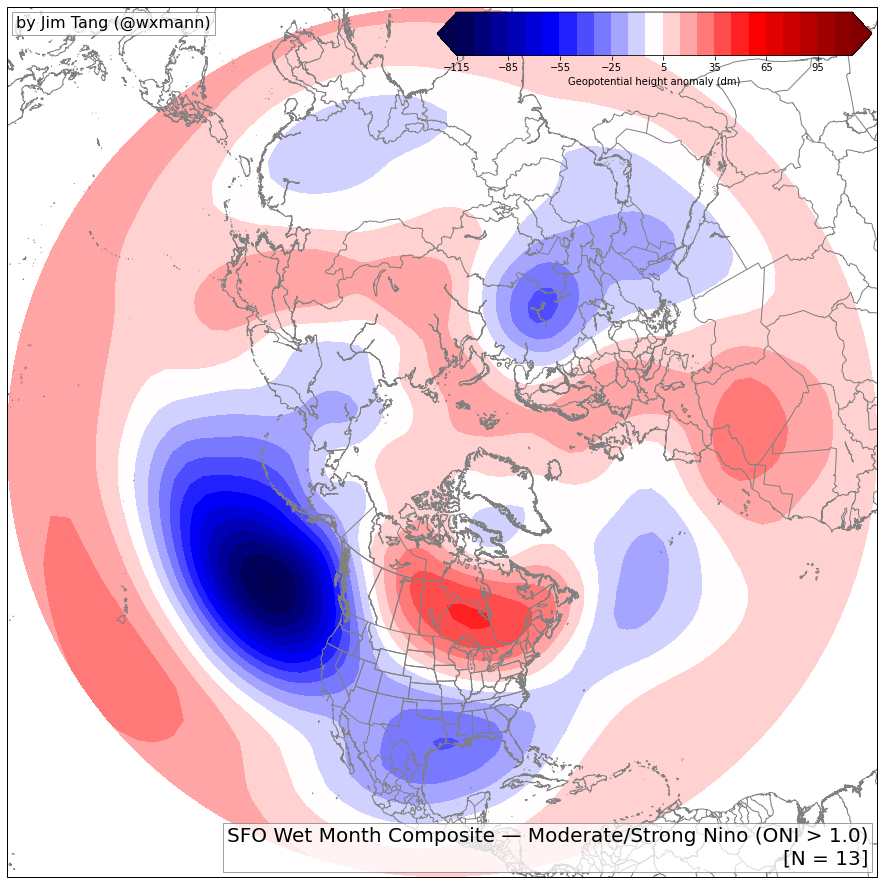

In [111]:
fig = plt.figure(figsize=(16, 16))

da = wet_nino_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — Moderate/Strong Nino (ONI > 1.0)\n[N = {len(wet_nino_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


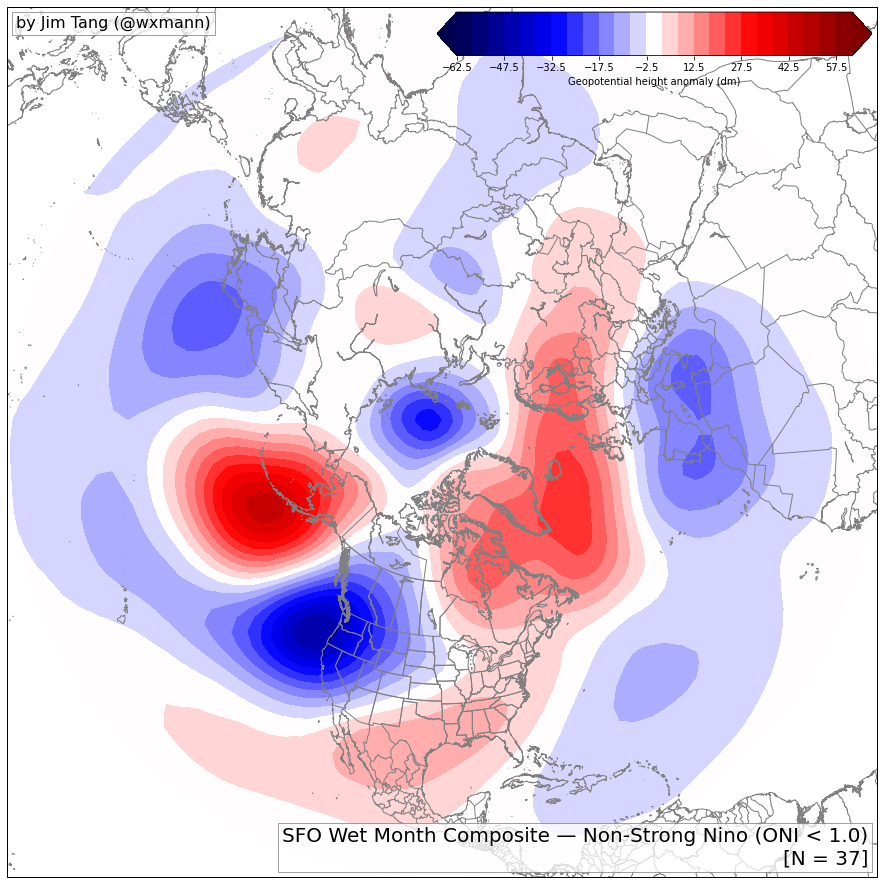

In [118]:
fig = plt.figure(figsize=(16, 16))

da = wet_neutral_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-62.5, 63, 5)
title = f'SFO Wet Month Composite — Non-Strong Nino (ONI < 1.0)\n[N = {len(wet_non_nino_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


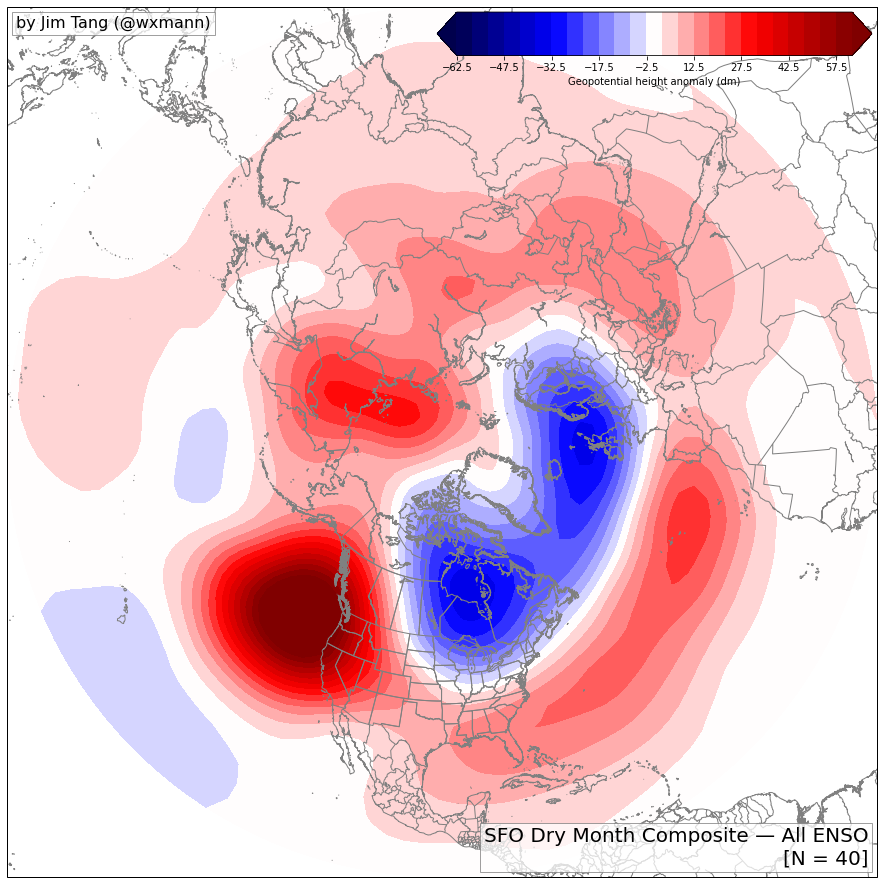

In [125]:
fig = plt.figure(figsize=(16, 16))

da = dry_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-62.5, 63, 5)
title = f'SFO Dry Month Composite — All ENSO\n[N = {len(dry_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

In [14]:
solver = Eof(anoms_wet.hgt)

# retrieve the first two EOFs from the solver class
eofs = solver.eofs(neofs=3)

In [15]:
# plt.figure(figsize=(16, 16))

# proj = ccrs.NorthPolarStereo(central_longitude=-94.5, true_scale_latitude=None, globe=None)
# m = maps.CartopyMap(proj=proj)
# m.draw()
# m.plot.fill(eofs[0], cmap='seismic')

In [16]:
# plt.figure(figsize=(16, 16))

# proj = ccrs.NorthPolarStereo(central_longitude=-94.5, true_scale_latitude=None, globe=None)
# m = maps.CartopyMap(proj=proj)
# m.draw()
# m.plot.fill(eofs[1], cmap='seismic')

In [17]:
# plt.figure(figsize=(16, 16))

# proj = ccrs.NorthPolarStereo(central_longitude=-94.5, true_scale_latitude=None, globe=None)
# m = maps.CartopyMap(proj=proj)
# m.draw()
# m.plot.fill(eofs[2], cmap='seismic')